# 2D Examples
These examples build upon the examples in the paper --- I also elaborate on a note in the paper, where I said the hexagonal lattice is not directly supported by our framework. By scaling the quincunx lattice, it's possible to obtain the hexagonal lattice. We first start by importing the LLVM bindings, then the analysis code, we also initialize the bindings.

In [1]:
%load_ext autoreload
%autoreload 2
import llvmlite.ir as ll
import llvmlite.binding as llvm
from ctypes import CFUNCTYPE, c_int, c_float
import ctypes

load('helpers.sage')
load('boxspline.sage')
load('lattice.sage')
load('splinespace.sage')
load('codegen.sage')
load('horner.sage')

# Setup the LLVM context
llvm.initialize()
llvm.initialize_native_target()
llvm.initialize_native_asmprinter()


## Define lattices
First, let's define the lattices that we'll be using, these are exactly the lattices used in the paper, with an additional lattice for good measure. We'll come back to the quincunx lattice at the end of this notebook.

In [2]:
L_quincunx = matrix([
    [1,-1],
    [1, 1]
])

L_cartesian = matrix([
    [1,0],
    [0,1]
])


# Here's a test case with a strange generating 
# matrix, which I'm calling the "prime" lattice
# (because its entries are all prime)
L_prime = matrix([
    [2,3],
    [-7,5]
])

In [3]:
# We recast these as IntegerLattice objects
L_quincunx = IntegerLattice(L_quincunx)
L_cartesian = IntegerLattice(L_cartesian)
L_prime = IntegerLattice(L_prime)

## Visualize
Just as a sanity check, let's visualize the lattices.


Cartesian lattice


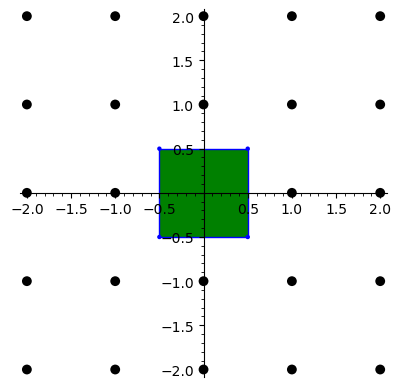

Quincunx lattice


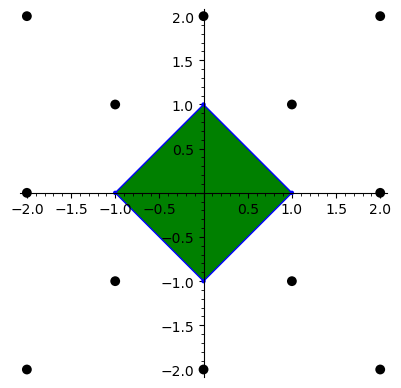

Prime lattice


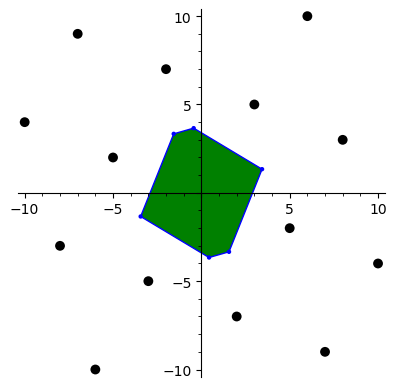

In [4]:
for t,L in [("Cartesian", L_cartesian), ("Quincunx", L_quincunx), ("Prime", L_prime)]:
    rmin = -10 if L == L_prime else -2
    rmax = 11 if L == L_prime else 3
    
    print(t, "lattice")
    pts = [p for p in product(range(rmin,rmax), range(rmin,rmax)) if L.is_lattice_site(p)]
    ( L.voronoi_region().plot() + points(pts, size=50, color='black')).show()
    
    
    

# ZP Element
We start with a tensor product spline on the Cartesian lattice --- this corresponds to one of the running examples in the paper.

In [5]:
zp_element = BoxSpline([
    (0,1),
    (1,0),
    (1,1),
    (-1,1)
])

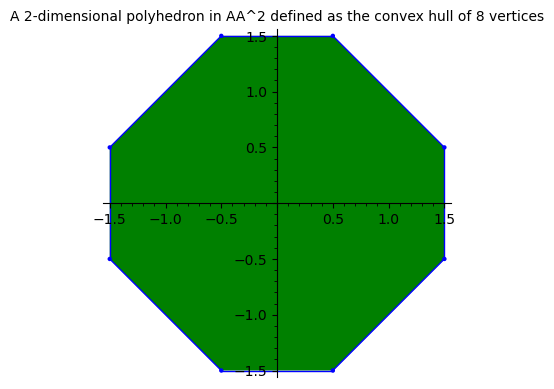

In [6]:
zp_element.get_polyhedron()

This is the main "analysis" class in this codebase. The spline space class combines a spline and a lattice and performs all the analysis in Part I of the paper. The spline can either be BoxSpline instance or a list of (polynomial, polyhedron) pairs. The lattice can be an integer matrix or an IntegerLattice instance. We disable the reflective symmetry optimization to reproduce the results in the paper.

In [7]:
ss = SplineSpace(zp_element, L_cartesian, enable_reflective=False)

Builing region of evaluation... done!
Symmetry analysis - signed permutation matrices...↻ ↻ ↻ ↻ ↻ ↻ ↻ ↻ done!
Symmetry analysis - reflections...✔ ✔ ✔ ✔ ✔ ✔ done!
Decomposing sub-regions - augmenting planes to create finer mesh...
Decomposing sub-regions - slicing ROE by fine mesh...
. . . . . . . . . . . 1/4 . . . . . . . . 2/4 . . . . . . . . 3/4 . . . . . . . . . . . 4/4 done!
Constructing sub-regions...
Decomposing sub regions - checking for reflective symmetry in ROE...
SplineSpace doesn't have reflective symmetry :<
Unrolling convolution sum - naming lattice sites... 
Unrolling convolution sum - distributing polynomials... . . . . . . . . . done!
Subregion symmetry analysis - cataloging reference regions...↷ (0/4) ↷ ↷ ↷ done!
Trimming ROE to only relevant subregions...
Reorienting planes...
Reording regions for redundancy removal...+ + + + done!
Creating BSP index...11 10 01 00 done!
Refining index...- - - - done!
Packing BSP index...(3, ✖) ✓ success with modulus 4, finished packi

We can look at all of the sub regions in the region of evaluation, and peek into the symmetry analysis between the sub-regions.

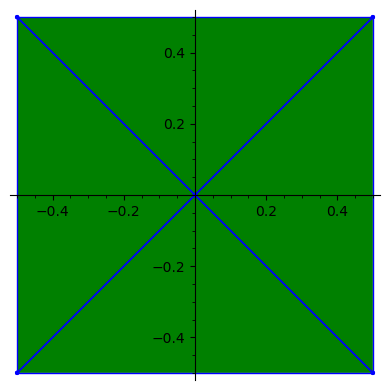

In [8]:
sum([_._region.plot() for _ in ss._subregions])

In [9]:
for idx, _ in enumerate(ss._subregions):
    print("Sub-region %s maps to sub-region %s" % (idx, _._ref_region))
    print("With shift %s and transformation:\n%s" % (_._transform[1], _._transform[0]))

Sub-region 0 maps to sub-region 0
With shift (0, 0) and transformation:
[1 0]
[0 1]
Sub-region 1 maps to sub-region 0
With shift (0, 0) and transformation:
[0 1]
[1 0]
Sub-region 2 maps to sub-region 0
With shift (0, 0) and transformation:
[ 0 -1]
[-1  0]
Sub-region 3 maps to sub-region 0
With shift (0, 0) and transformation:
[-1  0]
[ 0  1]


We can also plot the spline space to validate both that the spline space is valid, and that the decomposition code is working correctly. Note that this doesn't perform any code generation.

In [10]:
plot3d(lambda x,y: ss.eval_test([x,y])*2, (-2,2), (-2,2))

Graphics3d Object

You can optionally pass a function to the ```eval_test``` function which captures reads from lattice sites --- this function returns the value at a specific lattice site.

In [11]:
def memory_map(ls):
    x,y = ls # Unpack the input lattice site
    
    if x == 0 and y == 0:
        return 2
    
    if x == 1 and y == 2:
        return 1
    return 0

In [12]:
# plot3d(lambda x,y: ss.eval_test([x,y], memory_map)*2, (-3,3), (-3,3))

The EvalCodeGen class takes care of the remaining analysis needed for code generation (as well as doing the actual code generation). Here we set the generator to generate "abstract" lookups. This means that, whenever the data at a lattice site is needed, the generated code will call a user provided function that takes ``dimension`` interger paramerts that correspond to a lattice site, more on this below.

In [13]:
ecg = EvalCodeGen(ss, lookup_type = 'ABSTRACT')

Unknown architecture 'unknown' continuing with common PC parameters
Generating code for 'unknown':
   branchless: False
   branch_predication: False
   group_size: 1
   lane_count: 4
   refetch_transform: False
   lookup_type: ABSTRACT
Processing reference subregions...
Partitioning reference subregion 0 into cosets...  factoring... covering... + optimizing lookups... done!
Consistent subregions!


In [33]:
ecg.lane_count = 4

l = ecg.llvm_generate_vec()
print(l)



Generating...
<4 x i32>
doing shift
; ModuleID = "fastspline_codegen"
target triple = "unknown-unknown-unknown"
target datalayout = ""

declare <4 x float> @"llvm.round.v4f32"(<4 x float> %".1") 

declare <4 x float> @"llvm.floor.v4f32"(<4 x float> %".1") 

declare <4 x float> @"llvm.fabs.v4f32"(<4 x float> %".1") 

@"bsp_index" = constant [4 x i8] [i8 3, i8 2, i8 1, i8 0]
@"xform_lookup" = constant [4 x <{i8, i8, i8, i8, i8, i8}>] [<{i8, i8, i8, i8, i8, i8}> <{i8 1, i8 0, i8 0, i8 1, i8 0, i8 0}>, <{i8, i8, i8, i8, i8, i8}> <{i8 0, i8 1, i8 1, i8 0, i8 0, i8 0}>, <{i8, i8, i8, i8, i8, i8}> <{i8 0, i8 -1, i8 -1, i8 0, i8 0, i8 0}>, <{i8, i8, i8, i8, i8, i8}> <{i8 -1, i8 0, i8 0, i8 1, i8 0, i8 0}>]
define <4 x float> @"__reconstruct__"(<4 x float> %".1", <4 x float> %".2", float (i32, i32)* %".3") 
{
entry:
  %".5" = fsub fast <4 x float> %".1", <float              0x0, float              0x0, float              0x0, float              0x0>
  %".6" = fsub fast <4 x float> %".2", <float

We can take a look at the generated LLVM code

In [34]:
isinstance(ir.VectorType(ir.FloatType(), 1)(.0).type, ir.VectorType)

True

In [35]:
ir.VectorType(ir.FloatType().as_pointer(), 4).element.pointee

<<class 'llvmlite.ir.types.FloatType'> float>

Provided that you have the LLVM toolchain installed (I have LLVM-8 on my local machine), you can compile this code and include it in the current python address space. First we'll create a C wrapper for the above memory lookup function.

In [36]:
def memory_map(x,y):    
    if x == 0 and y == 0:
        return 2
    
    if x == 2 and y == 2:
        return 1
    return 0

# As a C function, we have a float return and two integers input parameters
c_memory_map_ft = CFUNCTYPE(c_float, c_int, c_int)
c_memory_map = c_memory_map_ft(memory_map)

In [37]:
# Parse and verify the generated code
mod = llvm.parse_assembly(l)
mod.verify()

# Create and 
with llvm.create_module_pass_manager() as pm:
    with llvm.create_pass_manager_builder() as pmb:
        pmb.populate(pm)
    pm.run(mod)

# Compile the code and get an address to the function
tm = llvm.Target.from_default_triple().create_target_machine()
ee = llvm.create_mcjit_compiler(mod, tm)
func = ee.get_function_address("__reconstruct__")

# Finally cast that address into a callable function
# returning a c_float, and takes two c_floats ans parameters, and a the memory map function
__reconstruct = CFUNCTYPE(c_float, c_float, c_float, c_memory_map_ft)(func)

Now we can call this like any other function

In [38]:
__reconstruct(0.,0., c_memory_map)

1.0

In [39]:
plot3d(lambda x,y: __reconstruct(x,y, c_memory_map)*2, (0,3), (0,3))

Graphics3d Object

We now elaborate on the second example in the paper, which is a tensor product linear spline on the quincunx lattice

In [21]:
G = matrix([
    [1,-1],
    [1, 1]
])

tp_spline = BoxSpline([
    (2,0),
    (0,2)
]*2)

rho = matrix.identity(2)*2


The point of this example is to show how the coset matrix can help simplify analysis, if we run the analysis here we obtain 4 subregions within the region of evaluation.

In [22]:
ss = SplineSpace(tp_spline, L_quincunx, rho=rho)

Builing region of evaluation... done!
Symmetry analysis - signed permutation matrices...↻ ↻ ↻ ↻ ↻ ↻ ↻ ↻ done!
Symmetry analysis - reflections...✔ ✔ ✔ done!
Decomposing sub-regions - augmenting planes to create finer mesh...
Decomposing sub-regions - slicing ROE by fine mesh...
. . . . . . . . . . . 1/2 . . . . . . . . . . . 2/2 done!
Constructing sub-regions...
Decomposing sub regions - checking for reflective symmetry in ROE...
SplineSpace doesn't have reflective symmetry :<
Unrolling convolution sum - naming lattice sites... 
Unrolling convolution sum - distributing polynomials... . . . . . . . . . . . . . done!
Subregion symmetry analysis - cataloging reference regions...↷ (0/4) ↷ ↷ ↷ done!
Trimming ROE to only relevant subregions...
Reorienting planes...
Reording regions for redundancy removal...+ + + + done!
Creating BSP index...10 11 00 01 done!
Refining index...- - - - - - done!
Packing BSP index...(3, ✖) ✓ success with modulus 4, finished packing BSP!


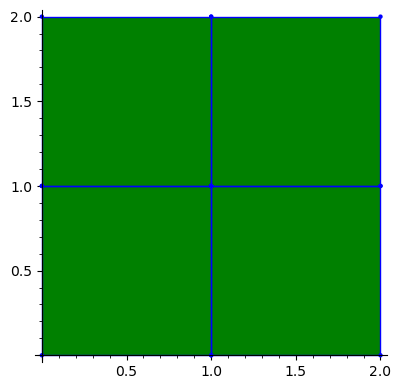

In [23]:
sum([_._region.plot() for _ in ss._subregions])

In [24]:
def memory_map(x):
    x,y = x
    if x == y == 0:
        return 1
    if x == y == 1:
        return 1
    if x == y == 1:
        return 1
    return 0
    
plot3d(lambda x,y: ss.eval_test([x,y],memory_map)*4, (-3,3), (-3,3))


Graphics3d Object

However, if we run this with the coset matrix povided in the paper, we end up with only one subregion.

In [25]:
ss = SplineSpace(tp_spline, L_quincunx, coset_matrix=G, rho=rho)

Builing region of evaluation... done!
Symmetry analysis - signed permutation matrices...↻ ↻ ↻ ↻ ↻ ↻ ↻ ↻ done!
Symmetry analysis - reflections...✔ ✔ ✔ done!
Decomposing sub-regions - augmenting planes to create finer mesh...
Decomposing sub-regions - slicing ROE by fine mesh...
. . . . . . 1/2 . . . . . . 2/2 done!
Constructing sub-regions...
Decomposing sub regions - checking for reflective symmetry in ROE...
SplineSpace doesn't have reflective symmetry :<
Unrolling convolution sum - naming lattice sites... 
Unrolling convolution sum - distributing polynomials... . . . . done!
Subregion symmetry analysis - cataloging reference regions...↷ (0/1) done!
Trimming ROE to only relevant subregions...
Reorienting planes...
Reording regions for redundancy removal...+ done!
Creating BSP index... done!
Refining index...- - done!
Packing BSP index...✓ success with modulus 1, finished packing BSP!


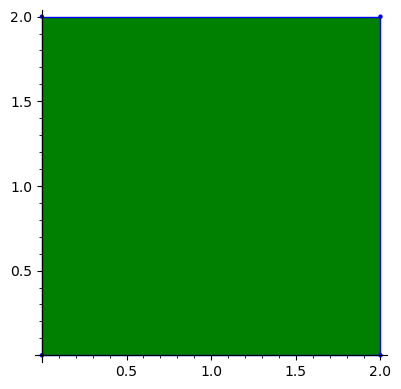

In [26]:
sum([_._region.plot() for _ in ss._subregions])

However, with the reflective symmetry optimization and the rest of the default parameters, the spline space is also decomposed in a reasonable way. 

In [27]:
ss = SplineSpace(tp_spline, L_quincunx)

Builing region of evaluation... done!
Symmetry analysis - signed permutation matrices...↻ ↻ ↻ ↻ ↻ ↻ ↻ ↻ done!
Symmetry analysis - reflections...✔ ✔ ✔ done!
Decomposing sub-regions - augmenting planes to create finer mesh...
Decomposing sub-regions - slicing ROE by fine mesh...
. . . . . . . . . . . 1/2 . . . . . . . . . . . 2/2 done!
Constructing sub-regions...
Decomposing sub regions - checking for reflective symmetry in ROE...
SplineSpace has reflective symmetry!
Subregion symmetry analysis - Pruning redundant regions
Unrolling convolution sum - naming lattice sites... 
Unrolling convolution sum - distributing polynomials... . . . . . . . . . . . . . done!
Subregion symmetry analysis - cataloging reference regions...↷ (0/1) done!
Trimming ROE to only relevant subregions...
Reorienting planes...
Reording regions for redundancy removal...+ done!
Creating BSP index... done!
Refining index...- - done!
Packing BSP index...✓ success with modulus 1, finished packing BSP!


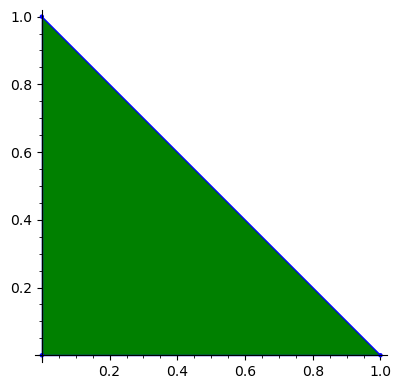

In [28]:
sum([_._region.plot() for _ in ss._subregions])

The default parameters for SplineSpace should be correct for most cases (provided you give a spline with partition of unity as input). The default parametes are often quite reasonable.

 Here's a bonus example on the quincunx lattice.

In [29]:
zpqc_spline = BoxSpline([
    (2,0),
    (0,2),
    (-1,1),
    (1,1)
]) 

ss = SplineSpace(zpqc_spline, L_quincunx)

Builing region of evaluation... done!
Symmetry analysis - signed permutation matrices...↻ ↻ ↻ ↻ ↻ ↻ ↻ ↻ done!
Symmetry analysis - reflections...✔ ✔ ✔ ✔ ✔ ✔ done!
Decomposing sub-regions - augmenting planes to create finer mesh...
Decomposing sub-regions - slicing ROE by fine mesh...
. . . . . . . . 1/4 . . . . . . . . . . . 2/4 . . . . . . . . . . . 3/4 . . . . . . . . 4/4 done!
Constructing sub-regions...
Decomposing sub regions - checking for reflective symmetry in ROE...
SplineSpace has reflective symmetry!
Subregion symmetry analysis - Pruning redundant regions
Unrolling convolution sum - naming lattice sites... 
Unrolling convolution sum - distributing polynomials... . . . . . . . . . done!
Subregion symmetry analysis - cataloging reference regions...↷ (0/1) done!
Trimming ROE to only relevant subregions...
Reorienting planes...
Reording regions for redundancy removal...+ done!
Creating BSP index... done!
Refining index...- - done!
Packing BSP index...✓ success with modulus 1, fin

In [30]:
plot3d(lambda x,y: ss.eval_test([x,y])*4, (-3,3), (-3,3))


Graphics3d Object

Again, to show you that the code is somewhat robust, here's an example on the prime lattice.

In [31]:
bsw = BoxSpline([(-5,2), (8,3), (3,5), (-2,7)])
ss = SplineSpace(bsw, L_prime)

Builing region of evaluation... done!
Symmetry analysis - signed permutation matrices...↻ x x ↻ x x x x done!
Symmetry analysis - reflections...☠ ☠ ☠ ☠ ☠ ☠ ☠ ☠ done!
Decomposing sub-regions - augmenting planes to create finer mesh...
Decomposing sub-regions - slicing ROE by fine mesh...
. . . . . . . . 1/4 . . . . . . . . 2/4 . . . . . . . . . . . 3/4 . . . . . . . . . 4/4 done!
Constructing sub-regions...
Decomposing sub regions - checking for reflective symmetry in ROE...
SplineSpace doesn't have reflective symmetry :<
Unrolling convolution sum - naming lattice sites... 
Unrolling convolution sum - distributing polynomials... . . . . . . . . . . . . . . . done!
Subregion symmetry analysis - cataloging reference regions...↷ (0/10) ⌧ (1/10) ⌧ (2/10) ↷ ⌧ (4/10) ↷ (5/10) ⌧ (6/10) ↷ ↷ ↷ done!
Trimming ROE to only relevant subregions...
Reorienting planes...
Reording regions for redundancy removal...+ + + + + + + + + + done!
Creating BSP index...00001011 00101011 01100001 00101001 00101101

In [32]:
plot3d(lambda x,y: ss.eval_test([x,y])*1000, (-10,10), (-10,10))

KeyboardInterrupt: 

In [ ]:
cubic_spline = BoxSpline([
    (0,1),
    (1,0),
]*4)
ss = SplineSpace(cubic_spline, L_cartesian)

In [ ]:
ecg = EvalCodeGen(ss, lookup_type = 'ABSTRACT')

In [ ]:
with open('bspline.ll', 'wb') as ll:
    ll.write(ecg.llvm_generate().encode())

# Hexagonal Lattice Splines

I mentioned in the paper that the hexagonal lattice isn't covered by our framework directly, but can be made to work by making the observation that the quincunx lattice is /almost/ the hexagonal lattice. A simple scaling along the axes makes it hexagonal. The following matrix does that.

In [ ]:
M = matrix([
    [2,0],
    [0,2/sqrt(3)]
])

We can then define following box spline (which is a variation of the courant element, also a scaled version of the hexagonal box spline).

In [ ]:
bs = BoxSpline([
    (2,0),
    (1, 1),
    (1, -1)
])

In [ ]:
sum([_['polyhedron'].plot() for _ in bs.get_pp_regions()])

This passes easily through the analysis

In [ ]:
ss = SplineSpace(bs, L_quincunx)

All one needs to do is scale by the above matrix to obtain an approximation on the hexagonal lattice

In [ ]:
def  memory_map(x):
    x,y = x
    if x == y == 0 or (x == 2 and y == 0) :
        return 1
    return 0

plot3d(lambda x,y: ss.eval_test([x*2,y*2/sqrt(3)], memory_map)*4, (-2,2),(-2,2))

Slightly more challenging, are the Voronoi spline on the hexagonal lattice. First we derive the hex splines (see the original Hex Splines paper, or Voronoi Splines --- I use the approach from the Voronoi Spline paper).

In [ ]:
H_ = matrix([
    [1,1,0],
    [1,0,1],
    [0,1,1]
])

# Set the order of the spline
order_n = 2

def vec_to_hex_bs(v):
    e1 = (0, 2/3)
    e2 = (1, -1/3)
    e3 = (-1, -1/3)
    return [e1]*v[0] + [e2]*v[1] + [e3]*v[2]

# Determine the support of the voronoi spline
support = None
dice = []
sl = []
order_n = 2

print("Determining support")

for s in int_solutions_to(order_n,3):
    print(s)
    bs = BoxSpline(vec_to_hex_bs(H_*vector(s)),centered=False)
    sl += [bs.get_polyhedron()]
    if support is None:
        support = bs.get_polyhedron()
    else:
        support = Polyhedron(vertices = support.vertices() + bs.get_polyhedron().vertices(), base_ring=AA)
        
    dice += list(set(sum([[(x,y,z) for (x,y,z) in region.Hrepresentation()]  for region in bs.get_regions()],[])))
    
dice = list(set(dice))

support.plot()

print("Slicing support")
regions = [support]
for d,nx,ny in dice:
    new_regions = []
    for r in regions:
        A,B = split_polyhedron(r, (nx,ny), d)
        if A is None or B is None:
            new_regions += [r]
        else:
            new_regions += [A,B]
    regions = new_regions[:]
    print(".", end=' ')
    
print("\nDistributing polynomials")

regions = [(_,0) for _ in regions]
support = None
dice = []
for s in int_solutions_to(order_n,3):
    print(s)
    bs = BoxSpline(vec_to_hex_bs(H_*vector(s)), centered=False)
    c = n_choose_rho(order_n, s)/3**order_n
    for bsregion in bs.get_pp_regions():
        for i, (r,pp) in enumerate(regions):
            if r.intersection(bsregion['polyhedron']).volume() > 0:
                regions[i] = (r, pp + c*bsregion['polynomial'])

By default, SplineSpace will use the indicator of the lattice as the region of evaluation (in red below). This might look a little harrowing, but the SplineSpace class can handle this (the best r.o.e would be the squished hexagon, but that doesn't seem to help the analysis any, so we leave this as-is for now)

In [ ]:
sum([r[0].plot() for r in regions])  + L_quincunx.voronoi_region().plot(color='red')

In [ ]:
ss = SplineSpace(regions, L_quincunx)

In [ ]:
ss.eval_test

For the sake of completing this example, let's codegen this spline space and plot it.

In [ ]:
ecg = EvalCodeGen(ss, lookup_type = 'ABSTRACT', branchless=True, branch_predication=True)

In [ ]:
l = ecg.llvm_generate()

In [ ]:
# Parse and verify the generated code
mod = llvm.parse_assembly(l)
mod.verify()

# Create and 
with llvm.create_module_pass_manager() as pm:
    with llvm.create_pass_manager_builder() as pmb:
        pmb.populate(pm)
    pm.run(mod)

# Compile the code and get an address to the function
tm = llvm.Target.from_default_triple().create_target_machine()
ee = llvm.create_mcjit_compiler(mod, tm)
func = ee.get_function_address("__reconstruct__")

# Finally cast that address into a callable function
# returning a c_float, and takes two c_floats ans parameters, and a the memory map function
__reconstruct = CFUNCTYPE(c_float, c_float, c_float, c_memory_map_ft)(func)

In [ ]:
def memory_map(x,y):    
    if x == 0 and y == 0:
        return 1
    
#     if x == 2 and y == 2:
#         return 1
    return 0

c_memory_map = c_memory_map_ft(memory_map)

# plot3d(lambda x,y: ss.eval_test((x*2,y*2/sqrt(3)), lambda a: memory_map(a[0],a[1])), (-2.0,2.1),(-2.0,2.0)) 

In [ ]:

plot3d(lambda x,y: 4*__reconstruct(x*2,y*2/sqrt(3), c_memory_map), (-1.5,1.5),(-1.5,1.5)) 

In [ ]:
plot3d(lambda x,y: __reconstruct(x,y, c_memory_map), (0.9,1.5),(0.25,0.5)) 

In [ ]:
__reconstruct(0.99,0.11, c_memory_map)

In [ ]:
# with open('hexagonal_linear.ll', 'wb') as lout:
#     lout.write(l.encode())

In [ ]:
dir(l)

In [ ]:
matrix([
    [-1,1],
    [1,1]
]).inverse()

In [ ]:
from llvmlite import ir

# Create some useful types
double = ir.DoubleType()
fnty = ir.FunctionType(double, (double, double))

# Create an empty module...
module = ir.Module(name="__file__")
# and declare a function named "fpadd" inside it
func = ir.Function(module, fnty, name="fpadd")

# Now implement the function
block = func.append_basic_block(name="entry")
builder = ir.IRBuilder(block)
a, b = func.args
result = builder.fadd(a, b, name="res")
builder.ret(result)

# Print the module IR
print(module)